<a href="https://colab.research.google.com/github/khojwar/Master_Thesis/blob/main/14_(Improve5_Breakthrough_second_success_another_experiment)_pos_tagging_using_lstm_without_loosing_sentence_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task success Till now are :
Step 0:
1. retrieve tags from directrie's files and store in "tags" list
2. plots bar diagram for tags
  *   One axis represents tags
  *   Other axis represents counts

step 1: Extract sentences and pos_tags from xml file

Step 2: Word Embedding with word2vec

Step 3: Preprocessing and Dataset Preparation

Step 4: Splitting dataset into 70% train, 15% val, and 15% test

Step 5: build an LSTM model using Keras  (Droupout=0.3, hidden activation='relu' and output activation='softmax')

Step 6: Compile the model (loss='sparse_categorical_crossentropy',
 optimizer = Adam(learning_rate=0.01))

Step 7: Train the LSTM model with Train and val dataset (batch_size=128, epoch=10, verbos=1)

Step 8: Evaluate the model with test dataset

Step 9: Create a plot of accuracy and loss over time

Step 10: Save the trained model

Step 11: Load the trained model

Step 12: POS Tagging with the LSTM Model

# Features, limitation and recomendation for user
1. If input have unseen words in the sentences. It assign the word by "UNK" tag.
2. user input दिदा "बाट", "को", "का", "लाई", "ले", "मा" etc शब्द लाई छुटाइ दिदा POS TAGGING गर्दा accuracy धेरै हुन्छ, तेसैले छुतैदिनुहोला ।
3. can't deal with confilct words

In [1]:
# !pip install tensorflow
# !pip install --upgrade gensim

In [2]:
# import dependencies
import os
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Update this line
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout  # Update this line

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# authenticate and mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Chage directory to project folder
%cd /content/drive/MyDrive/Nepali POS Tagging/
%ls

/content/drive/MyDrive/Nepali POS Tagging
 002_Nepali_pos_tagging_SVM.ipynb
'003_(first_success)_pos_tagging_using_word2Vec_and_LSTM.ipynb'
'006_( To_Improve4_first_success)_pos_tagging_using_word2Vec_and_GRU_LSTM_BiLSTM.ipynb'
'13_(Improve4_Breakthrough_second_success_another_experiment)_pos_tagging_using_lstm_without_loosing_sentence_sentiment.ipynb'
 2_nnc_updated_ah/
 nnc_updated_ah/
 trained_model/


# Access the book directory's xml files and create tagsets list

In [5]:
# Set the path to the directory containing XML files
path = '2_nnc_updated_ah/gc/books/'
filelist = os.listdir(path)
filelist

['book-academic-jana-siksha-2058.xml',
 'book-academic-swasthya-samaj-ra-rajniti-2062.xml',
 'book-autobiography-mero-aviral-jivangit-2060.xml',
 'book-academic-rupantaran-2062.xml',
 'book-anthropology-sabai-jatko-fulbari-2055.xml']

In [6]:
tagsets = []

for file in filelist:
    filepath = os.path.join(path, file)
    # print(filepath)

    tree = ET.parse(filepath)   # Parse an XML file and create an ElementTree object
    root = tree.getroot()   # Get the root element of the XML document
    # print(root)

    # Find all "w" elements with a "ctag" attribute
    word_elements = root.findall(".//w[@ctag]")

    # Extract POS tags
    tagset = [word.attrib["ctag"] for word in word_elements]
    tagsets.extend(tagset)


In [34]:
len(tagsets)

449669

# plot the code

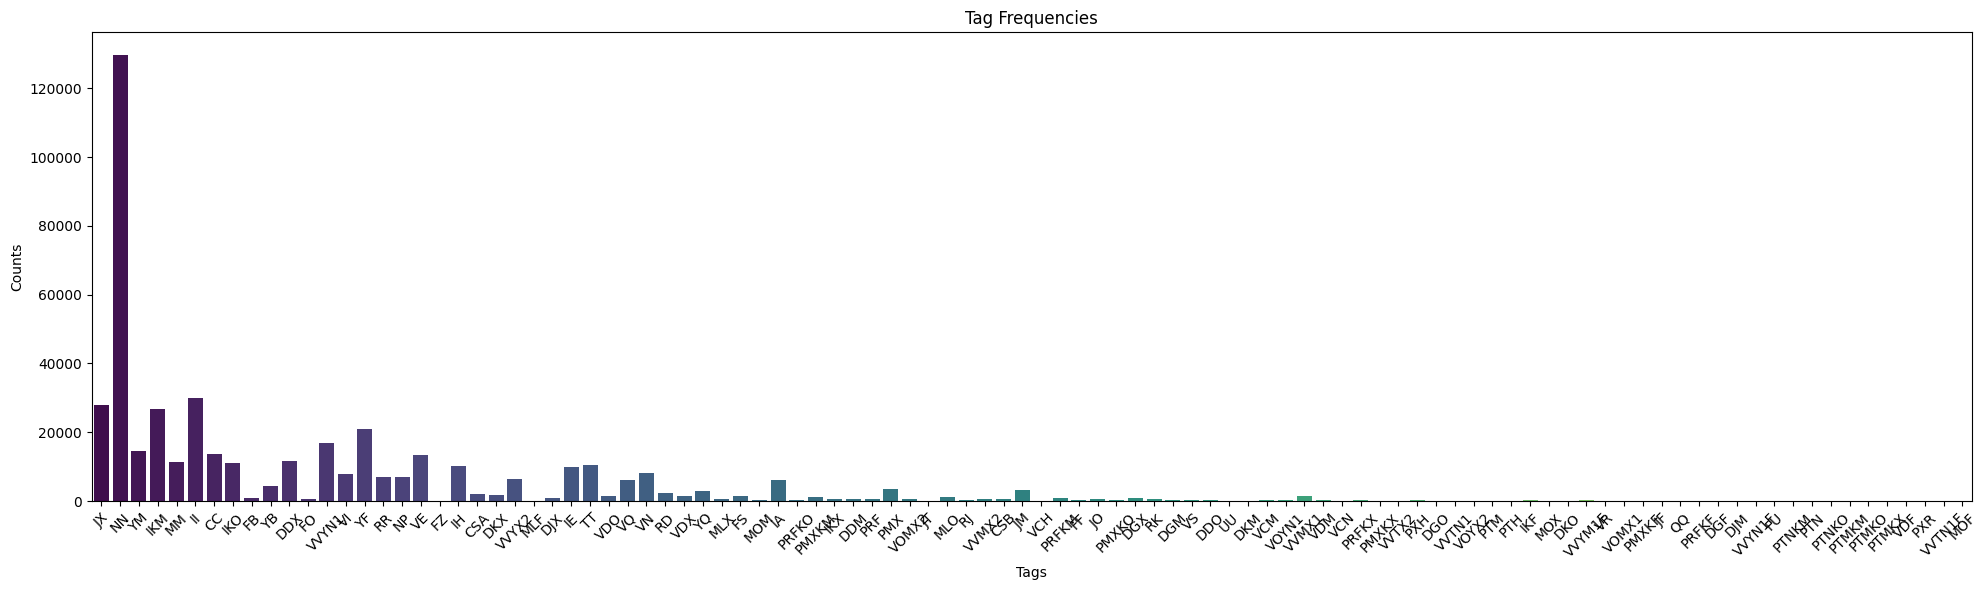

In [7]:
from collections import Counter
import pandas as pd

# Count the occurrences of each tag
tag_counts = Counter(tagsets)

# Convert the tag_counts to a DataFrame for Seaborn plotting
tag_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['Count']).reset_index()
tag_df.rename(columns={'index': 'Tag'}, inplace=True)

# Create a bar plot using Seaborn
plt.figure(figsize=(20, 6))
sns.barplot(x='Tag', y='Count', data=tag_df, palette='viridis')
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.title('Tag Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# step 1:  Extract sentences and pos_tags from xml file

In [8]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    sentences = []
    pos_tags = []
    for sentence in root.findall('.//s'):
        words = []
        tags = []
        for word_elem in sentence.findall('./w'):
            words.append(word_elem.text)
            tags.append(word_elem.get('ctag'))
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

In [ ]:
# Set the path to the directory containing XML files
path = '2_nnc_updated_ah/gc/books/'
filelist = os.listdir(path)
filelist

In [9]:
all_sentences = []
all_pos_tags = []

for file in filelist:
    filepath = os.path.join(path, file)
    sentences, pos_tags = parse_xml(filepath)

    all_sentences += sentences
    all_pos_tags += pos_tags

# Step 2: Word Embedding with word2vec

In [10]:
# created a Word2Vec model using Gensim in Python
from gensim.models import Word2Vec

def train_word2vec(sentences, embedding_dim=100):
    model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    return model

In [11]:
# Step 2: Word Embedding with word2vec
embedding_model = train_word2vec(all_sentences)
# embedding_model.wv.key_to_index


# Step 3: Preprocessing

In [12]:
# Create vocabulary and POS tag mapping

#-----------------------------------------------------------------------------------
# vocab = set([word for sentence in all_sentences for word in sentence])
# pos_tags_set = set([tag for tags in all_pos_tags for tag in tags])
# word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}
# tag_to_idx = {tag: idx for idx, tag in enumerate(pos_tags_set)}
# idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
#-----------------------------------------------------------------------------------

# Create vocabulary and POS tag mapping
vocab = set([word for sentence in all_sentences for word in sentence])
pos_tags_set = set([tag for tags in all_pos_tags for tag in tags])

word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}
word_to_idx['UNK'] = 0
# word_to_idx = {'UNK': 0}
# word_to_idx.update({word: idx + 1 for idx, word in enumerate(vocab)})

tag_to_idx = {tag: idx + 1 for idx, tag in enumerate(pos_tags_set)}
tag_to_idx['UNK'] = 0  # Add 'UNK' to the tag_to_idx dictionary
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

In [13]:
# Convert words and tags to indices
sentences_indices = [[word_to_idx[word] for word in sentence] for sentence in all_sentences]
pos_tags_indices = [[tag_to_idx[tag] for tag in tags] for tags in all_pos_tags]


In [14]:
# Pad sequences
max_sequence_length = max([len(seq) for seq in sentences_indices])
sentences_indices_padded = pad_sequences(sentences_indices, maxlen=max_sequence_length)
pos_tags_indices_padded = pad_sequences(pos_tags_indices, maxlen=max_sequence_length)


# Step 4: Splitting dataset into 70% train, 15% val, and 15% test

In [15]:
# Splitting data into 70% train, 30% temp
sentences_train, sentences_temp, pos_tags_train, pos_tags_temp = train_test_split(sentences_indices_padded, pos_tags_indices_padded, test_size=0.3, random_state=42)

# Splitting temp data into 50% val and 50% test
sentences_val, sentences_test, pos_tags_val, pos_tags_test = train_test_split(sentences_temp, pos_tags_temp, test_size=0.5, random_state=42)

# Step 5: Build the LSTM model

In [16]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_to_idx) + 1, output_dim=300, input_length=max_sequence_length))    # (number of unique words, 300-dimensional vector)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Adding a dropout layer with 30% dropout rate
model.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model.add(TimeDistributed(Dense(len(tag_to_idx), activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 303, 300)          9917100   
                                                                 
 lstm (LSTM)                 (None, 303, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 303, 128)          0         
                                                                 
 dense (Dense)               (None, 303, 64)           8256      
                                                                 
 time_distributed (TimeDistr  (None, 303, 101)         6565      
 ibuted)                                                         
                                                                 
Total params: 10,151,569
Trainable params: 10,151,569
Non-trainable params: 0
____________________________________________

`(None, 303, 300)` represents the shape of the input and output of this embedding layer. Here, None indicates that the batch size can vary, 303 is the sequence length of each input, and 300 is the dimensionality of the embedding vector.

# Step 6: Compile the model

In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Step 7: Train the LSTM model with Train and val dataset

In [18]:
# Train the model
history = model.fit(sentences_train, pos_tags_train, epochs=3, batch_size=128, validation_data=(sentences_val, pos_tags_val), verbose=1)

Epoch 1/3
126/126 [==============================] - 321s 3s/step - loss: 0.2183 - accuracy: 0.9611 - val_loss: 0.0301 - val_accuracy: 0.9933
Epoch 2/3
126/126 [==============================] - 308s 2s/step - loss: 0.0202 - accuracy: 0.9954 - val_loss: 0.0131 - val_accuracy: 0.9972
Epoch 3/3
126/126 [==============================] - 315s 2s/step - loss: 0.0086 - accuracy: 0.9980 - val_loss: 0.0132 - val_accuracy: 0.9978


# Step 8: Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [19]:
# history_dict = history.history
# history_dict.keys()

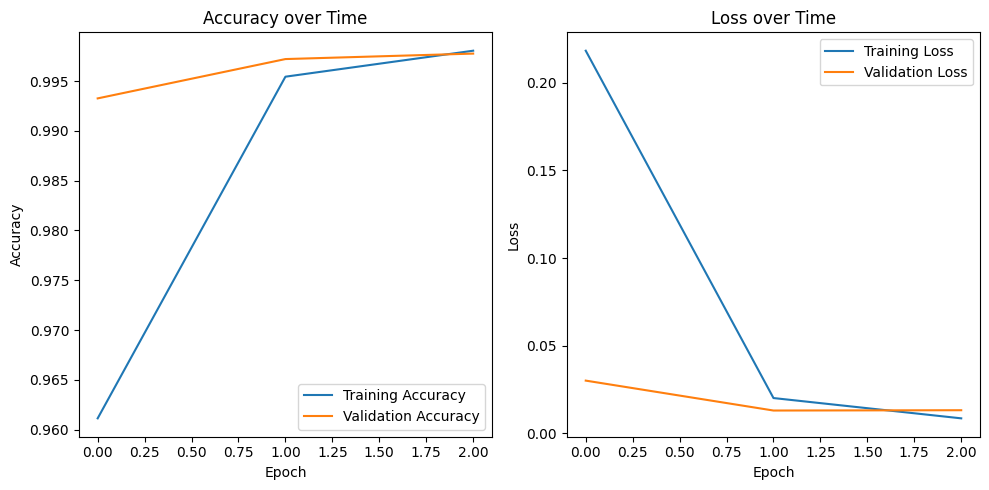

In [20]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Save the trained model

In [21]:
# Save the trained model
model.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_LSTM/")

# Step 10: Load the trained model

In [22]:
from keras.models import load_model

# Load the trained model
LSTM_model = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_LSTM/")

# Step 11: Evaluate the model

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(sentences_test, pos_tags_test, verbose=1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

108/108 [==============================] - 29s 269ms/step - loss: 0.0129 - accuracy: 0.9978
Loss: 0.012928574346005917,
Accuracy: 0.9978112578392029


# Step 12: Plot the confusion matrix using Seaborn

108/108 [==============================] - 28s 250ms/step


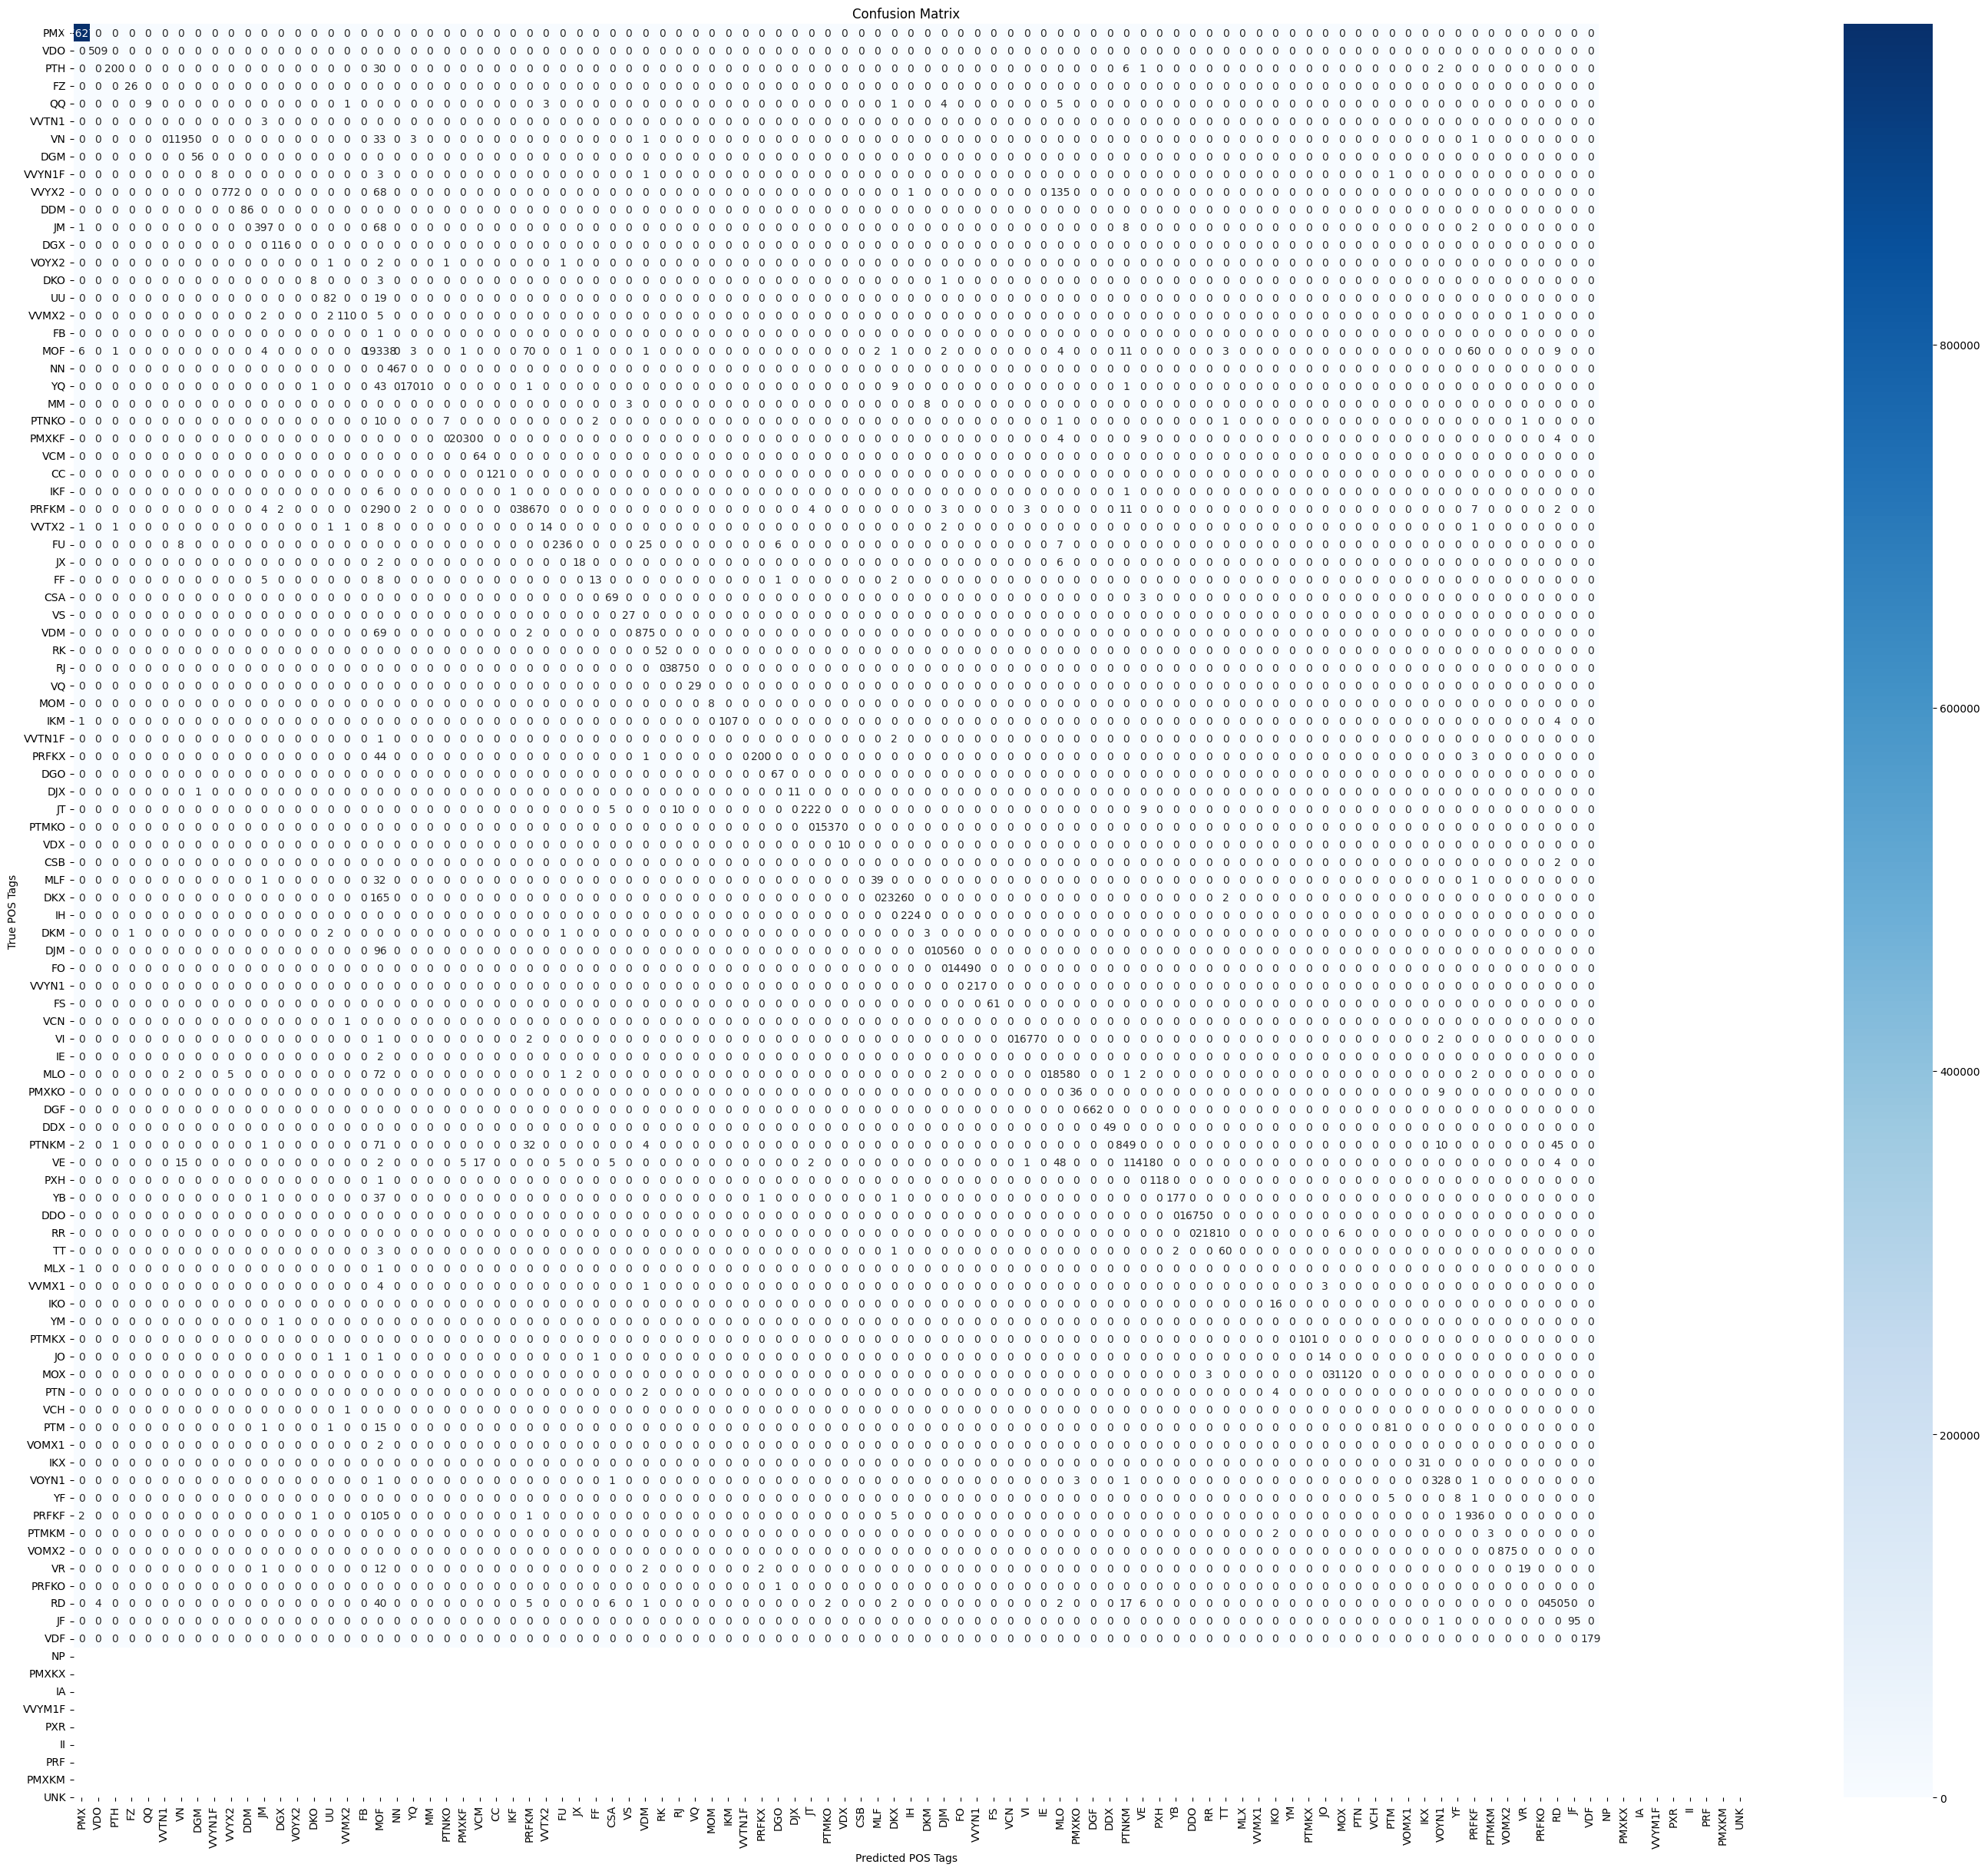

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict POS tags using the trained model
predicted_tags = model.predict(sentences_test)
predicted_tags = np.argmax(predicted_tags, axis=-1)

# Flatten the true and predicted tags arrays
true_tags_flat = np.ravel(pos_tags_test)
predicted_tags_flat = np.ravel(predicted_tags)

# Create a confusion matrix
confusion_mat = confusion_matrix(true_tags_flat, predicted_tags_flat)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(35, 30))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_tag.values(), yticklabels=idx_to_tag.values())
plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix')
plt.show()


# Step 13: Calculate precision, recall, F1 score and accuracy

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_tags_flat, predicted_tags_flat, average='weighted')
recall = recall_score(true_tags_flat, predicted_tags_flat, average='weighted')
f1 = f1_score(true_tags_flat, predicted_tags_flat, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9978
Recall: 0.9978
F1 Score: 0.9977
Accuracy: 0.9978


In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: राम लेख लेख । 
1/1 [==============================] - 0s 55ms/step
राम: DGX
लेख: NN
लेख: NN
।: YF


In [32]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: २०२० को दशकदेखि कम्युनिस्ट पार्टीको निकटमा रहेर पार्टी निर्माणका लागि गीत गाउँदै हिँडे उनी । २०६६ मा उनी माओवादीमा प्रवेश गरे । त्यसयता माओवादीका लागि उनले आफ्नो स्वर दिँदै आएका थिए । २०७० मा उनी संविधानसभा सदस्य समेत भएका थिए । क्रान्तिकारी गीत गाएकै कारण उनी कयौंपटक जेल जानुपर्‍यो । उनी तत्कालीन मालेका नेता मात्रै नभई सांस्कृतिक टोलीका नेता पनि थिए । उनले पार्टीको लागि गाउँदै हिँड्दा जीवन गुजाराका लागि कपडा पसलदेखि साग बेच्नेसम्म र किताब पसल तथा होटलसमेत चलाए ।
1/1 [==============================] - 0s 175ms/step
२०२०: YM
को: IKM
दशकदेखि: NN
कम्युनिस्ट: NN
पार्टीको: UNK
निकटमा: UNK
रहेर: VQ
पार्टी: NN
निर्माणका: UNK
लागि: II
गीत: NN
गाउँदै: VDX
हिँडे: NN
उनी: DDX
।: YF
२०६६: NN
मा: II
उनी: DDX
माओवादीमा: NN
प्रवेश: NN
गरे: VE
।: YF
त्यसयता: NN
माओवादीका: UNK
लागि: II
उनले: NN
आफ्नो: PRFKM
स्वर: NN
दिँदै: VDX
आएका: NN
थिए: VVYX2
।: YF
२०७०: NN
मा: II
उनी: DDX
संविधानसभा: NN
सदस्य: NN
समेत: II
भएका: NN
थिए: VVYX2
।: YF
क्रान्तिकारी: JX
गीत: NN
गाएकै: NN
कारण: NN
उनी: 

In [29]:
len(word_to_idx) + 1

33057

# Step 14: From the loaded model "LSTM_model"

In [30]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = LSTM_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word} : {pos_tag}')

Enter a sentence: राम लेख लेख । 
1/1 [==============================] - 1s 523ms/step
राम : DGX
लेख : NN
लेख : NN
। : YF


In [33]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = LSTM_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word} : {pos_tag}')

Enter a sentence: २०२० को दशक देखि कम्युनिस्ट पार्टी को निकट मा रहेर पार्टी निर्माण का लागि गीत गाउँदै हिँडे उनी । २०६६ मा उनी माओवादी मा प्रवेश गरे । त्यसयता माओवादी का लागि उनले आफ्नो स्वर दिँदै आए का थिए । २०७० मा उनी संविधानसभा सदस्य समेत भए का थिए । क्रान्तिकारी गीत गाएकै कारण उनी कयौंपटक जेल जानुपर्‍यो । उनी तत्कालीन माले का नेता मात्रै नभई सांस्कृतिक टोली का नेता पनि थिए । उनले पार्टी को लागि गाउँदै हिँड्दा जीवन गुजारा का लागि कपडा पसल देखि साग बेच्नेसम्म र किताब पसल तथा होटलसमेत चलाए ।
1/1 [==============================] - 0s 90ms/step
२०२० : YM
को : IKM
दशक : NN
देखि : II
कम्युनिस्ट : NN
पार्टी : NN
को : IKM
निकट : JX
मा : II
रहेर : VQ
पार्टी : NN
निर्माण : NN
का : IKO
लागि : II
गीत : NN
गाउँदै : VDX
हिँडे : NN
उनी : DDX
। : YF
२०६६ : NN
मा : II
उनी : DDX
माओवादी : NN
मा : II
प्रवेश : NN
गरे : VE
। : YF
त्यसयता : NN
माओवादी : NN
का : IKO
लागि : II
उनले : NN
आफ्नो : PRFKM
स्वर : NN
दिँदै : VDX
आए : VE
का : IKO
थिए : VVYX2
। : YF
२०७० : NN
मा : II
उनी : DDX
संविधानसभा : NN
सदस्

# GRU

# 1. Train And Compile GRU model
### Note:
If your target labels are integer class indices: Use `sparse_categorical_crossentropy`.

It expects the target labels to be of shape `(batch_size,)`, where each entry represents the class index of the corresponding sample.

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
If your target labels are already one-hot encoded: Use `categorical_crossentropy`.

It expects the target labels to be of shape `(batch_size, num_classes)` where each row is a one-hot encoded vector corresponding to the class of the sample.

Otherwise it gives error.

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
model2 = Sequential()
model2.add(Embedding(input_dim=len(word_to_idx) + 1, output_dim=300, input_length=max_sequence_length))    # (number of unique words, 300-dimensional vector)
model2.add(GRU(128, return_sequences=True))    # Using GRU layer instead of LSTM
model2.add(Dropout(0.3))  # Adding a dropout layer with 30% dropout rate
model2.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model2.add(TimeDistributed(Dense(len(tag_to_idx), activation='softmax')))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 303, 300)          9917100   
                                                                 
 gru_1 (GRU)                 (None, 303, 128)          165120    
                                                                 
 dropout_2 (Dropout)         (None, 303, 128)          0         
                                                                 
 dense_4 (Dense)             (None, 303, 64)           8256      
                                                                 
 time_distributed_2 (TimeDis  (None, 303, 101)         6565      
 tributed)                                                       
                                                                 
Total params: 10,097,041
Trainable params: 10,097,041
Non-trainable params: 0
__________________________________________

In [37]:
from tensorflow.keras.optimizers import Adam

model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [40]:
# Train the model
history2 = model2.fit(sentences_train, pos_tags_train, epochs=3, batch_size=128, validation_data=(sentences_val, pos_tags_val), verbose=1)

Epoch 1/3
126/126 [==============================] - 310s 2s/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0118 - val_accuracy: 0.9979
Epoch 2/3
126/126 [==============================] - 302s 2s/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0124 - val_accuracy: 0.9979
Epoch 3/3
126/126 [==============================] - 358s 3s/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0122 - val_accuracy: 0.9979


# Create a plot of accuracy and loss over time
model2.fit() returns a History object that contains a dictionary with everything that happened during training:

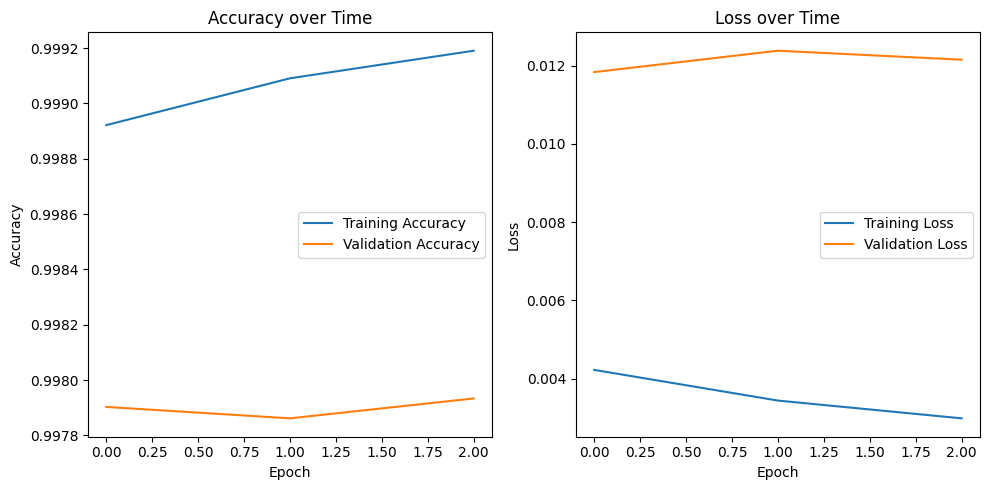

In [41]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Save the trained model
model2.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_GRU/")

In [43]:
from keras.models import load_model

# Load the trained model
GRU_loaded_model = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_GRU/")

In [44]:
# evaluate the model using test dataset
loss, accuracy = GRU_loaded_model.evaluate(sentences_test, pos_tags_test, verbose=1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

108/108 [==============================] - 23s 207ms/step - loss: 0.0119 - accuracy: 0.9980
Loss: 0.01193296629935503,
Accuracy: 0.9979732036590576


# Plot the confusion matrix using Seaborn

108/108 [==============================] - 23s 214ms/step


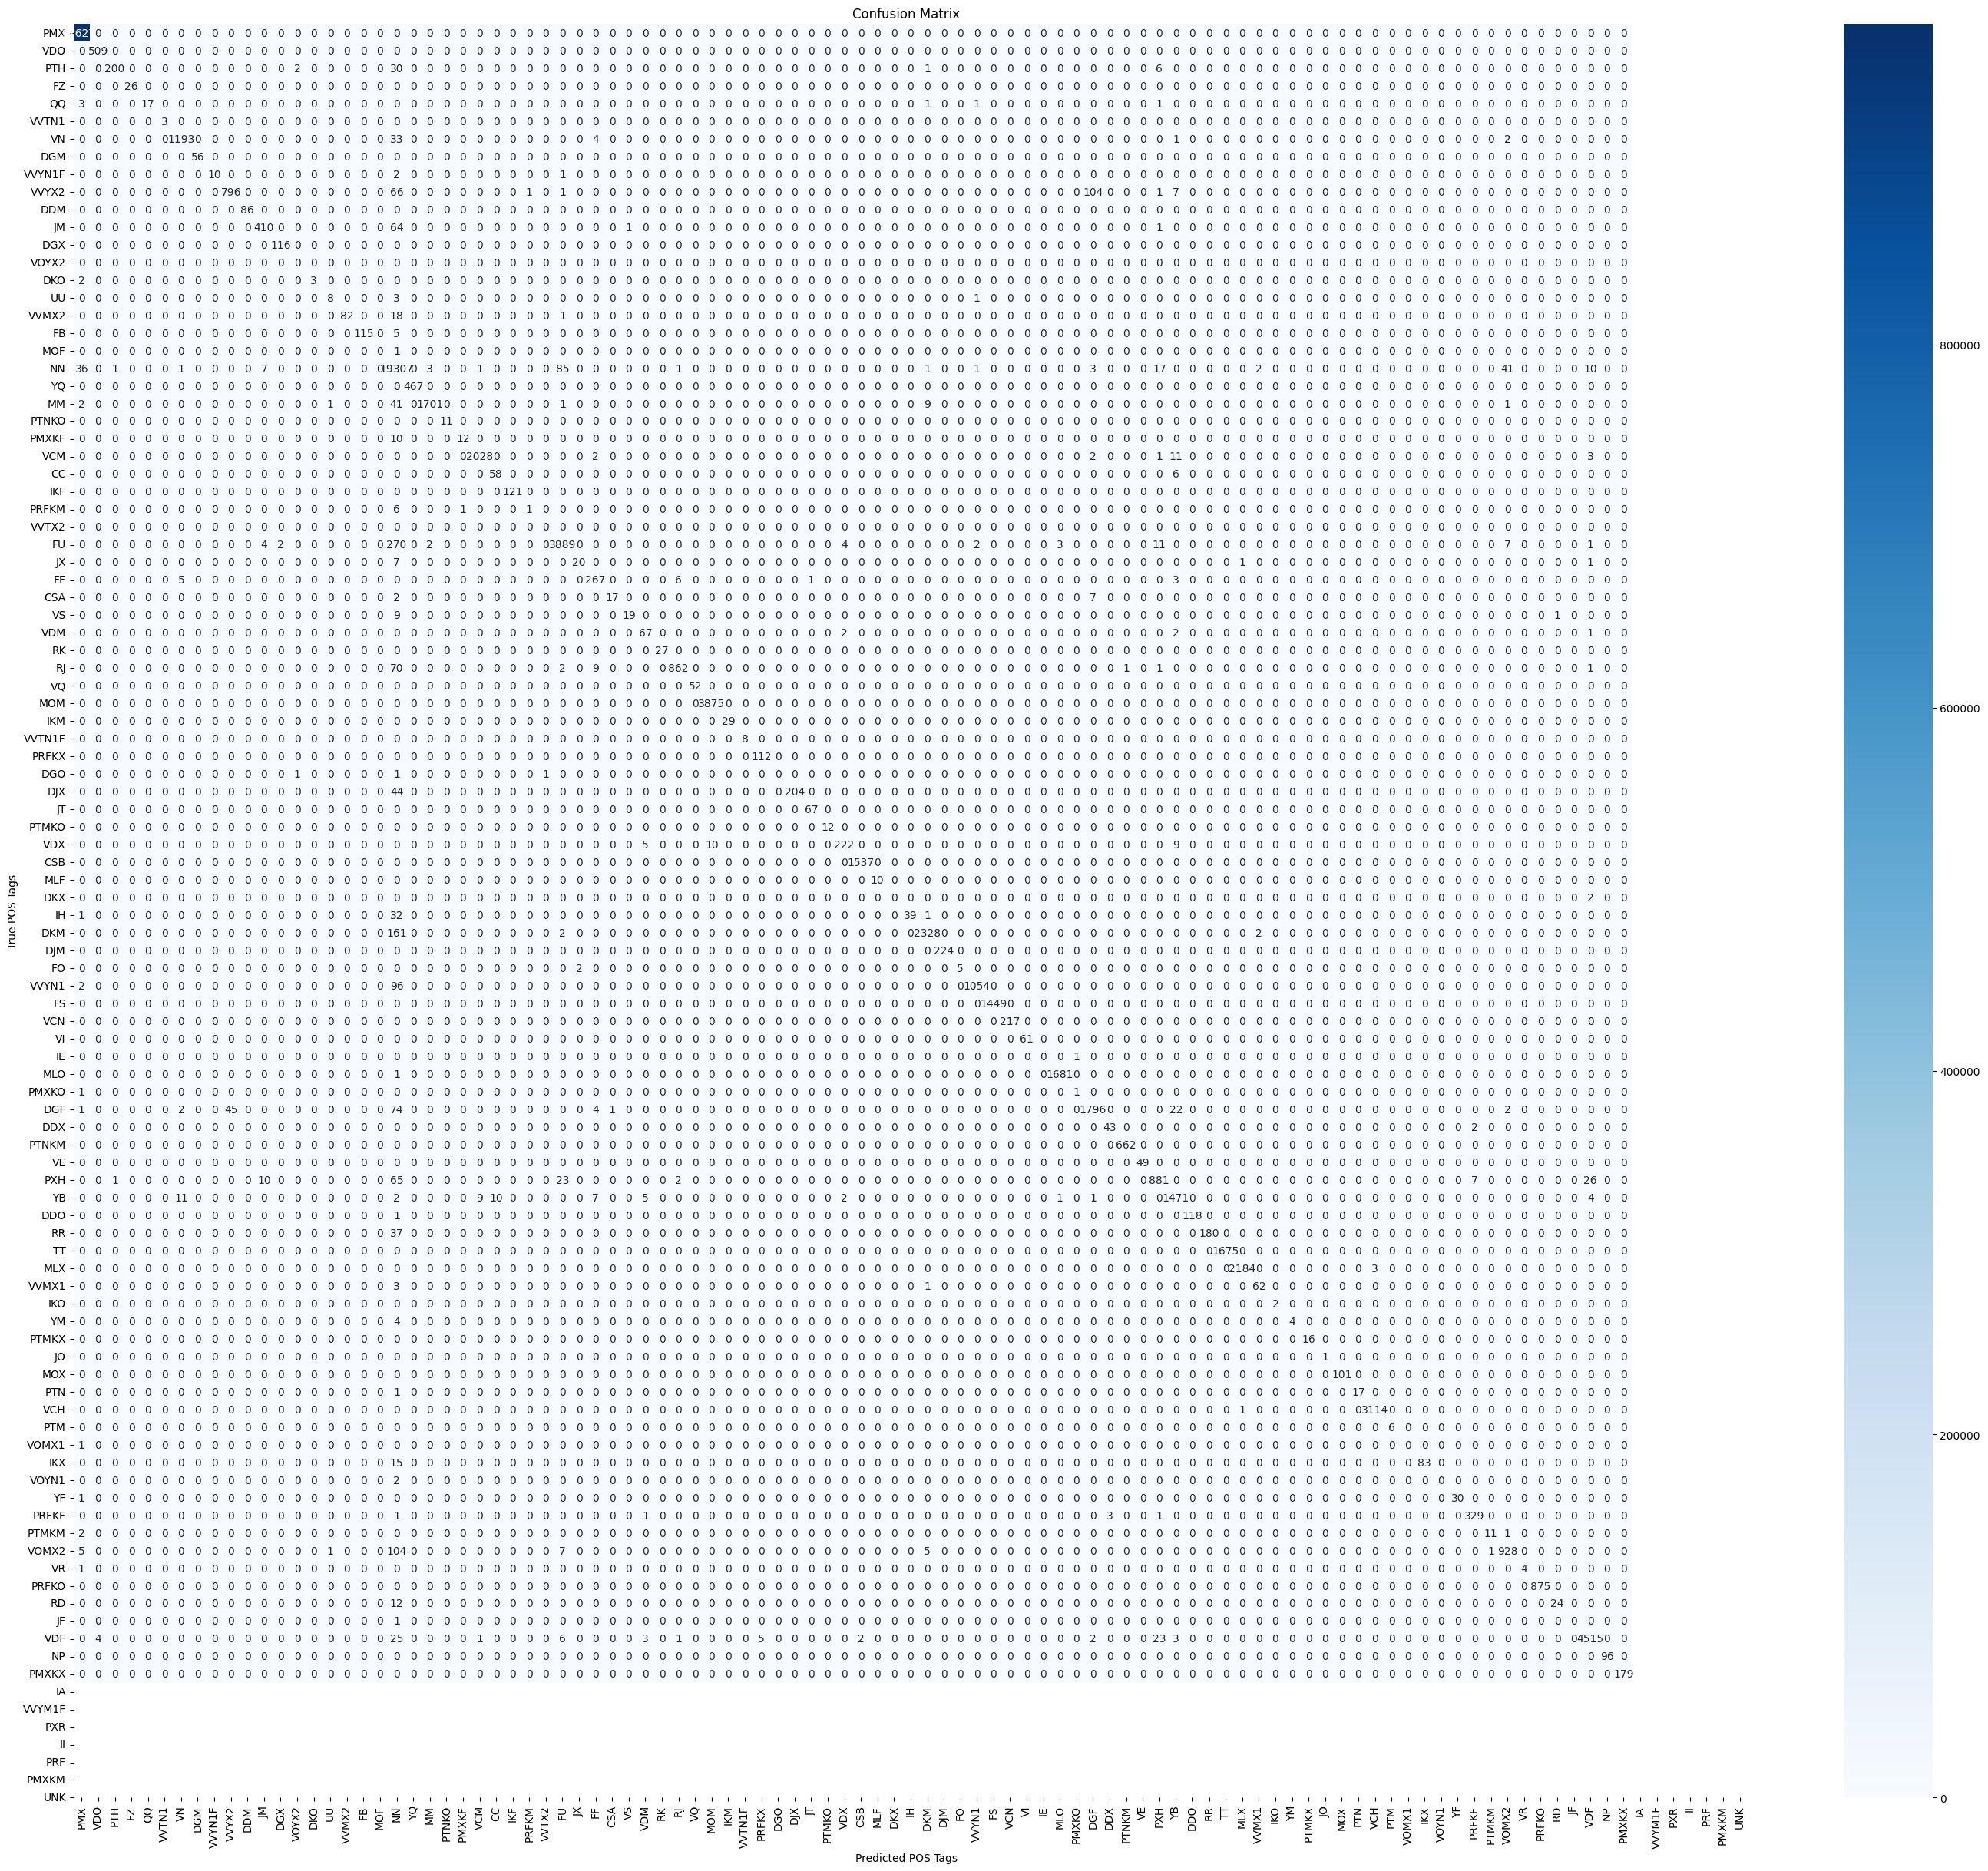

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict POS tags using the trained model
predicted_tags = GRU_loaded_model.predict(sentences_test)
predicted_tags = np.argmax(predicted_tags, axis=-1)

# Flatten the true and predicted tags arrays
true_tags_flat = np.ravel(pos_tags_test)
predicted_tags_flat = np.ravel(predicted_tags)

# Create a confusion matrix
confusion_mat = confusion_matrix(true_tags_flat, predicted_tags_flat)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(35, 30))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_tag.values(), yticklabels=idx_to_tag.values())
plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1 score and accuracy

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_tags_flat, predicted_tags_flat, average='weighted')
recall = recall_score(true_tags_flat, predicted_tags_flat, average='weighted')
f1 = f1_score(true_tags_flat, predicted_tags_flat, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9980
Recall: 0.9980
F1 Score: 0.9979
Accuracy: 0.9980


# For user Input pos tagging

In [47]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = GRU_loaded_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')

Enter a sentence: राम लेख लेख ।  
1/1 [==============================] - 0s 81ms/step
राम: TT
लेख: NN
लेख: NN
।: YF


# BiLSTM

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
model3 = Sequential()
model3.add(Embedding(input_dim=len(word_to_idx) + 1, output_dim=300, input_length=max_sequence_length))    # (number of unique words, 300-dimensional vector)
model3.add(Bidirectional(LSTM(128, return_sequences=True)))  # Using Bidirectional LSTM layer
model3.add(Dropout(0.3))  # Adding a dropout layer with 30% dropout rate
model3.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model3.add(TimeDistributed(Dense(len(tag_to_idx), activation='softmax')))

model3.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 303, 300)          9917100   
                                                                 
 bidirectional (Bidirectiona  (None, 303, 256)         439296    
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 303, 256)          0         
                                                                 
 dense_6 (Dense)             (None, 303, 64)           16448     
                                                                 
 time_distributed_3 (TimeDis  (None, 303, 101)         6565      
 tributed)                                                       
                                                                 
Total params: 10,379,409
Trainable params: 10,379,409


In [50]:
from tensorflow.keras.optimizers import Adam

model3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [51]:
history3 = model3.fit(sentences_train, pos_tags_train, epochs=3, batch_size=128, validation_data=(sentences_val, pos_tags_val), verbose=1)

Epoch 1/3
126/126 [==============================] - 618s 5s/step - loss: 0.1604 - accuracy: 0.9684 - val_loss: 0.0166 - val_accuracy: 0.9962
Epoch 2/3
126/126 [==============================] - 565s 4s/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.0095 - val_accuracy: 0.9978
Epoch 3/3
126/126 [==============================] - 561s 4s/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0091 - val_accuracy: 0.9980


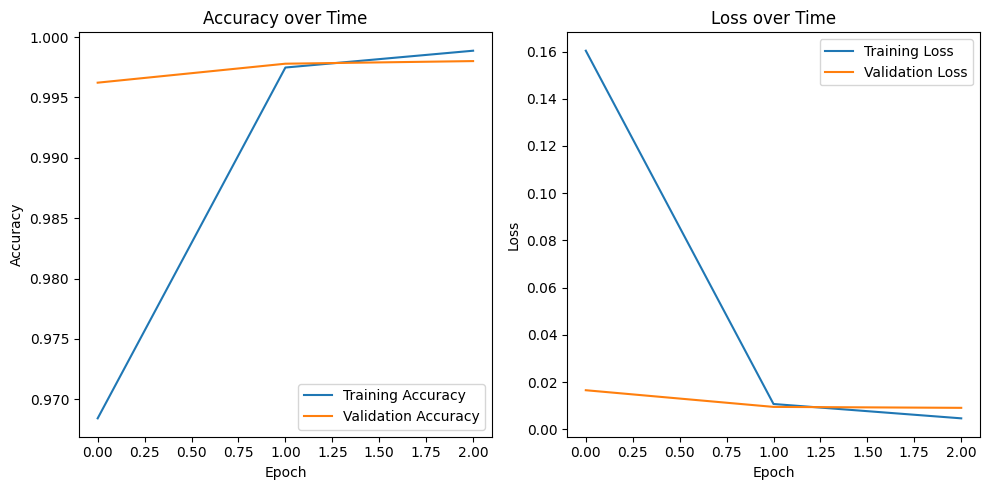

In [52]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Save the trained model
model3.save("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_BiLSTM/")

In [54]:
from keras.models import load_model

# Load the trained model
BiLSTM_loaded_model = load_model("/content/drive/MyDrive/Nepali POS Tagging/trained_model/2_BiLSTM/")

In [55]:
# evaluate the model using test dataset
loss, accuracy = BiLSTM_loaded_model.evaluate(sentences_test, pos_tags_test, verbose=1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

108/108 [==============================] - 50s 456ms/step - loss: 0.0091 - accuracy: 0.9981
Loss: 0.009118529967963696,
Accuracy: 0.9980518221855164


# Plot the confusion matrix using Seaborn

108/108 [==============================] - 48s 434ms/step


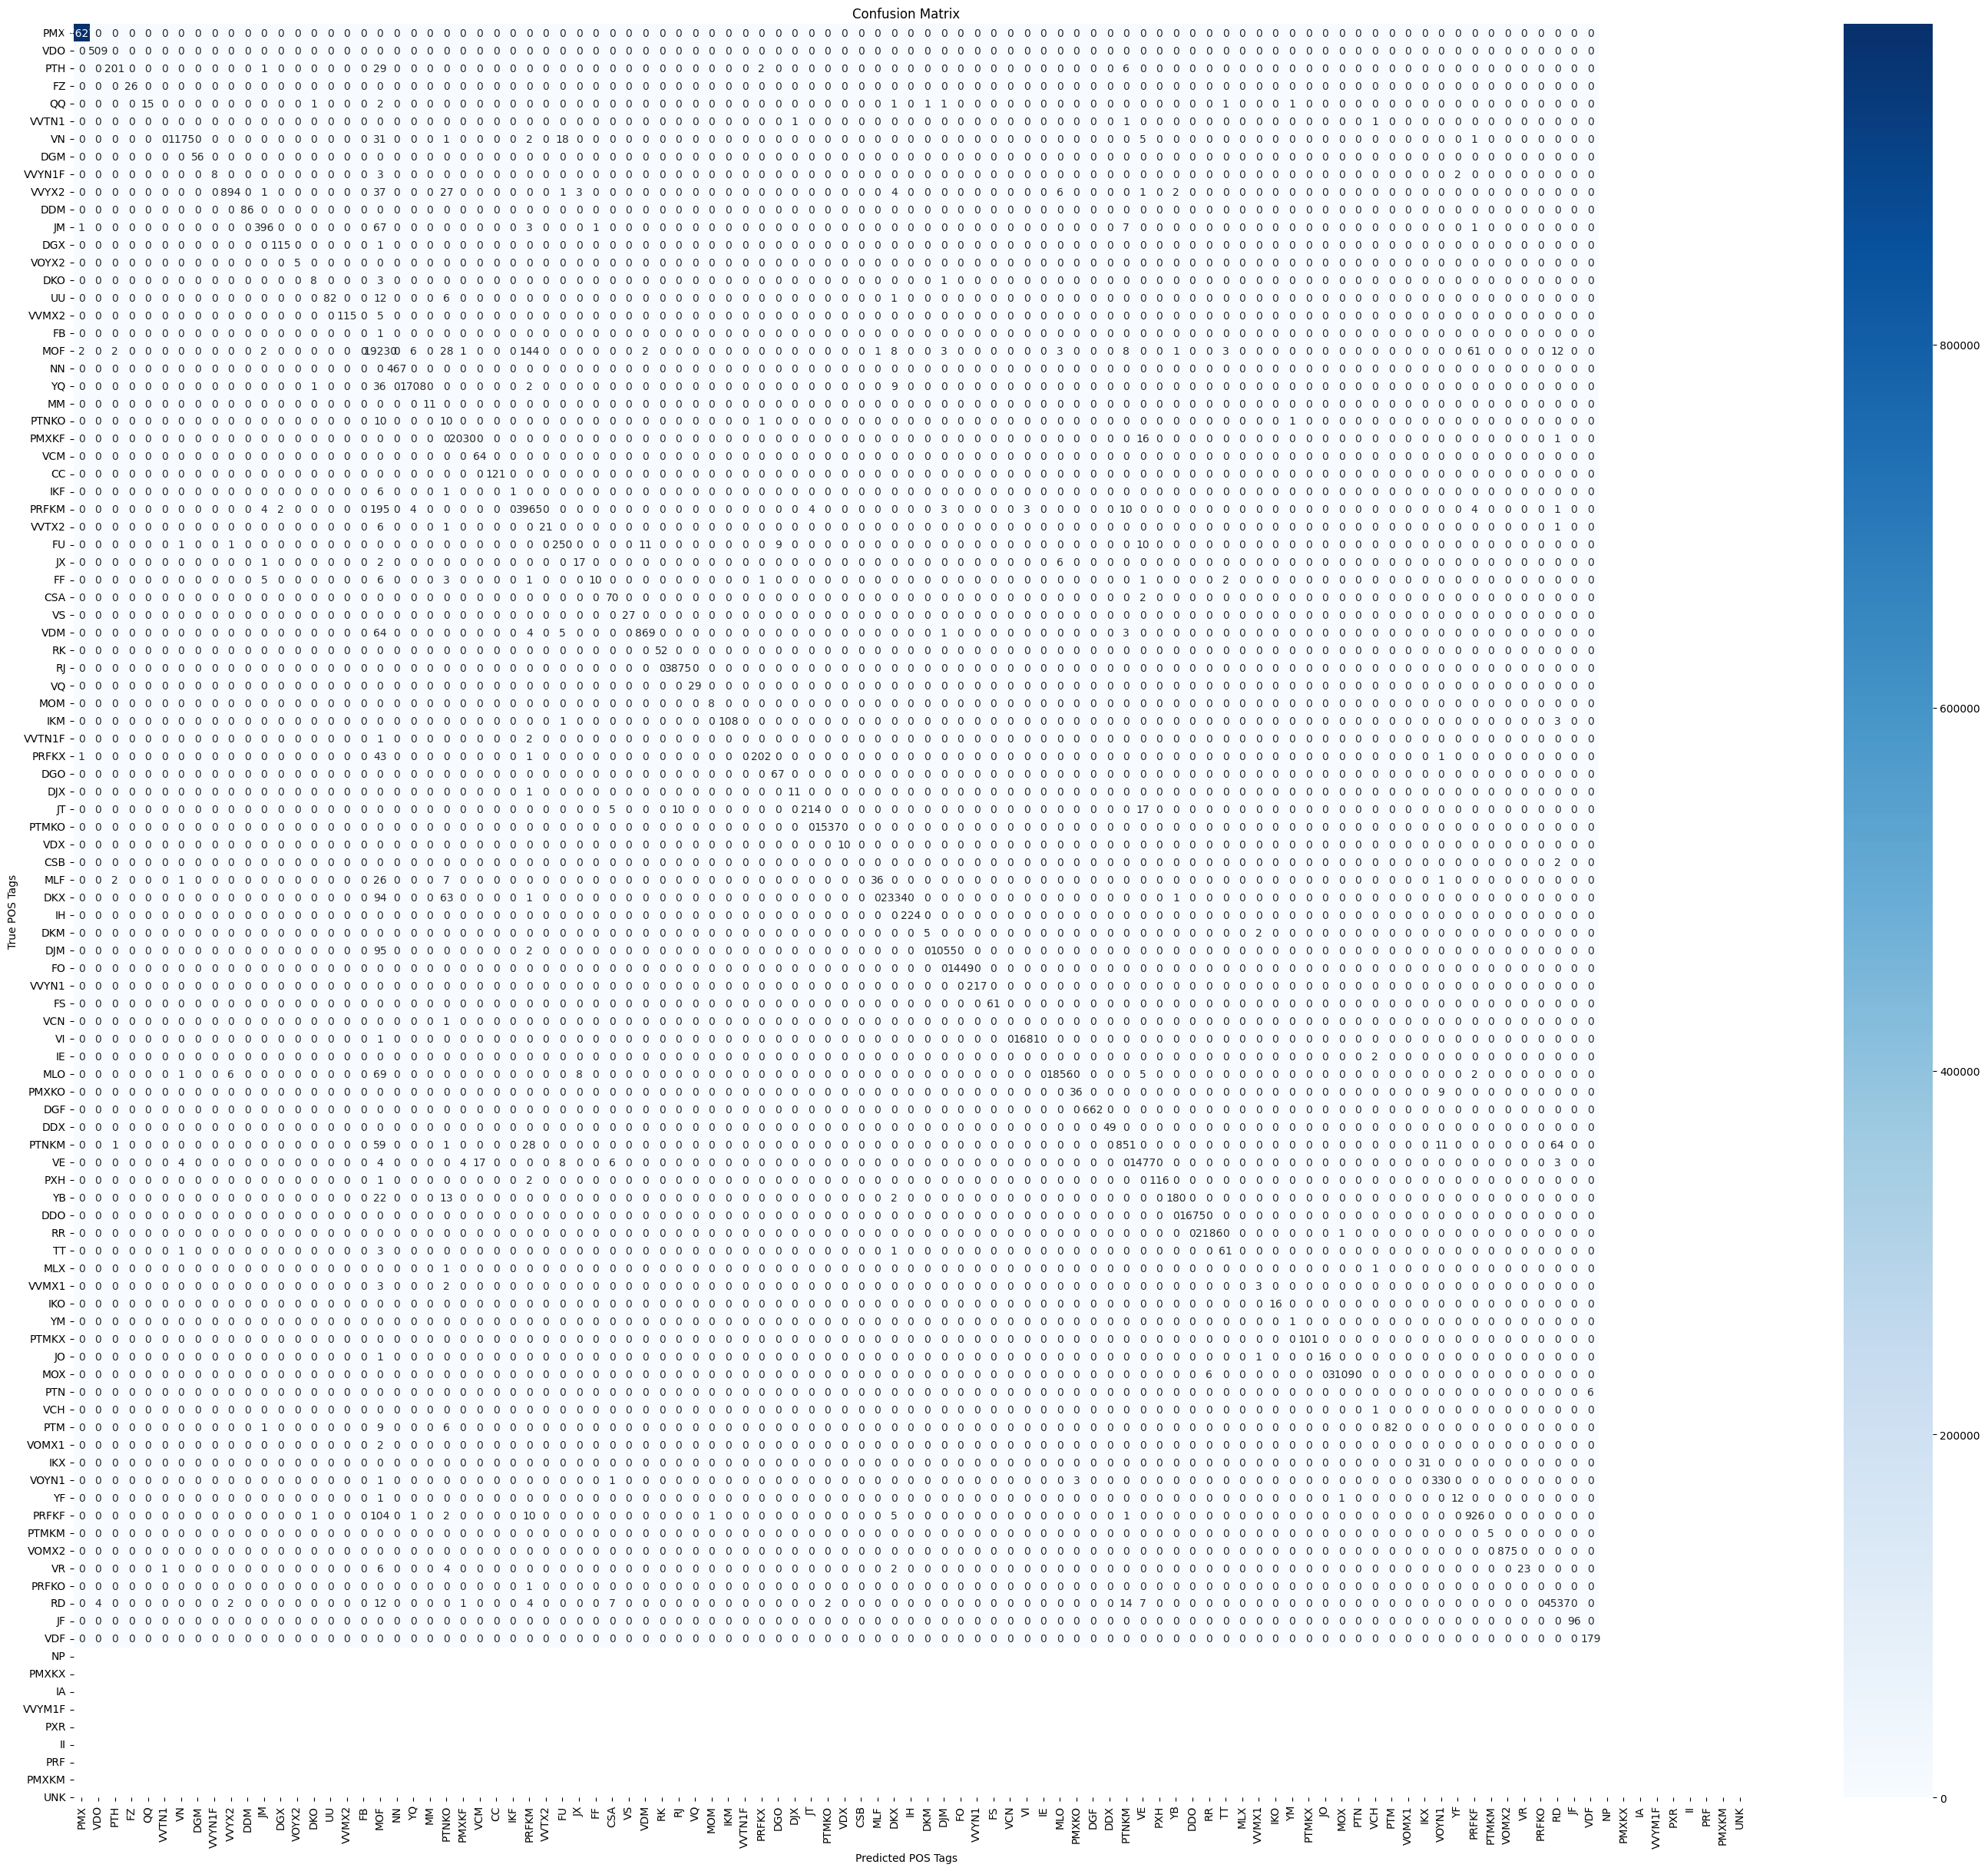

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict POS tags using the trained model
predicted_tags = BiLSTM_loaded_model.predict(sentences_test)
predicted_tags = np.argmax(predicted_tags, axis=-1)

# Flatten the true and predicted tags arrays
true_tags_flat = np.ravel(pos_tags_test)
predicted_tags_flat = np.ravel(predicted_tags)

# Create a confusion matrix
confusion_mat = confusion_matrix(true_tags_flat, predicted_tags_flat)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(35, 30))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_tag.values(), yticklabels=idx_to_tag.values())
plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1 score and  accuracy

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_tags_flat, predicted_tags_flat, average='weighted')
recall = recall_score(true_tags_flat, predicted_tags_flat, average='weighted')
f1 = f1_score(true_tags_flat, predicted_tags_flat, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9982
Recall: 0.9981
F1 Score: 0.9981
Accuracy: 0.9981


# For user Input pos tagging

In [58]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = GRU_loaded_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')

Enter a sentence: २०२० को दशक देखि कम्युनिस्ट पार्टी को निकट मा रहेर पार्टी निर्माण का लागि गीत गाउँदै हिँडे उनी । २०६६ मा उनी माओवादी मा प्रवेश गरे । त्यसयता माओवादी का लागि उनले आफ्नो स्वर दिँदै आए का थिए । २०७० मा उनी संविधानसभा सदस्य समेत भए का थिए । क्रान्तिकारी गीत गाएकै कारण उनी कयौंपटक जेल जानुपर्‍यो । उनी तत्कालीन माले का नेता मात्रै नभई सांस्कृतिक टोली का नेता पनि थिए । उनले पार्टी को लागि गाउँदै हिँड्दा जीवन गुजारा का लागि कपडा पसल देखि साग बेच्नेसम्म र किताब पसल तथा होटलसमेत चलाए ।
1/1 [==============================] - 0s 44ms/step
२०२०: MM
को: IKM
दशक: NN
देखि: II
कम्युनिस्ट: NN
पार्टी: NN
को: IKM
निकट: JX
मा: II
रहेर: VQ
पार्टी: NN
निर्माण: NN
का: IKO
लागि: II
गीत: NN
गाउँदै: VDX
हिँडे: NN
उनी: DDX
।: YF
२०६६: NN
मा: II
उनी: DDX
माओवादी: NN
मा: II
प्रवेश: NN
गरे: VE
।: YF
त्यसयता: NN
माओवादी: NN
का: IKO
लागि: II
उनले: NN
आफ्नो: PRFKM
स्वर: NN
दिँदै: VDX
आए: VE
का: IKO
थिए: VVYX2
।: YF
२०७०: NN
मा: II
उनी: DDX
संविधानसभा: NN
सदस्य: NN
समेत: II
भए: VE
का: IKO
थिए: VVYX2
।:

In [63]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = GRU_loaded_model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')

Enter a sentence: टिका लेख लेख ।  
1/1 [==============================] - 0s 51ms/step
टिका: UNK
लेख: NN
लेख: NN
।: YF
